# Continuous Control - Sample-based Distributional Policy Gradient

---

In this notebook is implemetation of Sample-based Distributional Policy Gradient (SDPG) algorithm on Lunar Modul.

### 1. Start the Environment
In the first step, we import necessary packages for our environment

In [1]:
#from unityagents import UnityEnvironment
from mlagents_envs.environment import UnityEnvironment
import gym
import numpy as np
import torch
from mlagents_envs.registry import default_registry

### 2. Set environment
At the second step, we set up the environment.

In [2]:
#set device
num_agents = 1

# set GPU or CPU fdevice for calculation
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
    DEVICE = "cpu"
    
env = gym.vector.make("LunarLander-v2", num_envs=num_agents, continuous = True)

### 3. Run environment and train the SDPG Agent

Section where the the SDPG Agent is set up and  trained

Episode 107 	Score: -157.44 (H: -157.44 / L: -157.44)	Moving average: -131.79 (H:  5.82 / L: -228.86)


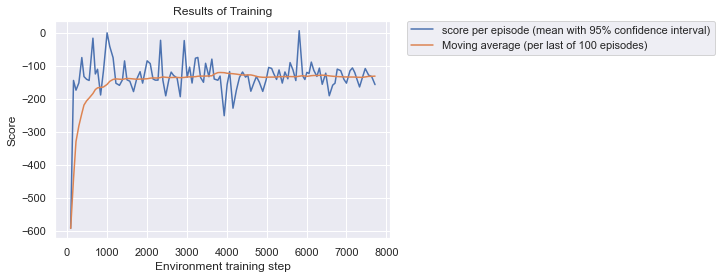

In [ ]:
from SDPG_agent import *
import torch
import seaborn as sns
from matplotlib import pyplot as plt
from IPython. display import clear_output
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

#set theme of plot
sns.set_theme(style="darkgrid")

def SDPG_algorithm(env, action_dim, state_dim, obs_state_range, action_range, device, n_episodes=2000, num_agents = 1):

    #parameter initialization
    scores = {'Environment training step': 0, 'score': [], 'average':[]} # dataframe containing scores from each episode
    scores = pd.DataFrame.from_dict(scores)
    scores_window = deque(maxlen=100*num_agents)       # window for moving average
    #least_score = -10.                                 # least score for saving of the model
    last_episode = None
    
    # init and set scaler
    scaler = MinMaxScaler()
    scaler.fit(np.squeeze(obs_state_range))
    
    # initialization of SDPG Agent
    agent = SDPGAgent(state_dim, action_dim, obs_state_range, action_range, device = device) 
    
    # episode section
    for i_episode in range(1, n_episodes+1):
        
        # reset score and number of episode
        score = np.zeros(num_agents)
        n_episode = 0
        
        #reset states in agents
        agent.random_process_fn.reset_states()
        
        
        # reset the environment
        states, _ = env.reset()
        
        # scale input
        states = scaler.transform(states) 

        while True:
            actions = [agent.select_action(state) for state in states] # select action for all environments
            next_states, rewards, terminateds, truncateds, info = env.step(actions)  # send all actions to the environment
            next_states = scaler.transform(next_states) # scale next states
            
            # start agent learning
            for state, action, next_state, reward, truncated in zip(states, actions, next_states, rewards, truncateds):
                agent.step(state, action, reward, next_state, truncated)

            
            score = score + rewards                           # update the score (for each agent)
            states = next_states                              # update states
             
            
            # if agent doesn't start with training, go back to while loop
            if agent.train_step == 0:
                continue
            else:
                n_episode += 1
            
            # show progress bar
            printProgressBar(t, 256, prefix = 'Steps:', suffix = '{}/{}'.format(t, 256),length = 50)
            
            # end while loop if some environment finished
            if np.sum(truncateds) or np.sum(terminateds):
                break
        
        # update score for moving average
        scores_window.append(score)    
        
        # print the results for this episode
        clear_output(wait=True)
        print('Episode {:3d} \tScore: {:5.2f} (H: {:5.2f} / L: {:5.2f})\t' \
              'Moving average: {:5.2f} (H: {:5.2f} / L: {:5.2f})' \
              .format(i_episode, score.mean(),
                      score.max(), score.min(),
                      np.mean(scores_window), np.max(scores_window),
                      np.min(scores_window)))
        
        # save model   
        agent.save_model('SDPG_Checkpoint')

            
        # print last saved model
        #if not last_episode == None:
           # print('Environment was saved in {:d}. episode.\tAverage Score: {:.2f} (H: {:5.2f} / L: {:5.2f})'\
                  #.format(last_episode, np.mean(least_score), np.max(least_score), np.min(least_score)))
        
        # add data to dictionary 
        dict_score = pd.DataFrame.from_dict({'Environment training step': agent.train_step, 'score': score, 'average':np.mean(scores_window)})
        scores = pd.concat([scores, dict_score],  axis = 0)    
        
        # plot graph
        sns.lineplot(data = scores.explode('score', ignore_index = True), x = "Environment training step", y = "score", legend='brief', label='score per episode (mean with 95% confidence interval)')
        sns.lineplot(data = scores, x = "Environment training step", y = "average", legend='brief', label='Moving average (per last of 100 episodes)')
        plt.xlabel('Environment training step')
        plt.ylabel('Score')
        plt.title('Results of Training')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
 
        scores_window.append(score)       # save average score
        
    return scores

# get parameters from environment 
obs_state_range = [env.observation_space.low, env.observation_space.high]
action_range = [env.action_space.low, env.action_space.high]
obs_space_dims = env.observation_space.shape[1]
action_space_dims = env.action_space.shape[1]

#start with training the SDPG Agent
scores = SDPG_algorithm(env, action_space_dims, obs_space_dims, obs_state_range, action_range, DEVICE, n_episodes=2000, num_agents = num_agents)

## 4. Close all environments

In [ ]:
env.close()

### 5. Testing Neural Network of SDPG Agent

In [ ]:
from SDPG_agent import *
import torch
import seaborn as sns
from matplotlib import pyplot as plt
from IPython. display import clear_output
import numpy as np
from gym import wrappers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import gym

# set device for GPU
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

#set environment
env = [gym.make("LunarLander-v2", render_mode='rgb_array', continuous = True) for _ in range(2)]

# get parameters from environment
obs_state_range = [np.ravel(env[0].observation_space.low), np.ravel(env[0].observation_space.high)]
action_range = [env[0].action_space.low.flatten(), env[0].action_space.high.flatten()]
obs_space_dims = env[0].observation_space.shape[0]
action_space_dims = env[0].action_space.shape[0]

# init and set scaler
scaler = MinMaxScaler()
scaler.fit(obs_state_range)

# get parameters from environment
action_range = [env[0].action_space.low, env[0].action_space.high]
states_train, _ = env[0].reset()                                   
states_untrain, _ = env[1].reset() 

agent_trained  = SDPGAgent(obs_space_dims, action_space_dims, obs_state_range, action_range, device = device) 
agent_untrained = SDPGAgent(obs_space_dims, action_space_dims, obs_state_range, action_range, device = device) 
agent_trained.load_model('SDPG_Checkpoint')

# section for preparation of plots
frames = []
fig, axes = plt.subplots(1, 2, figsize=(15, 15), tight_layout=True)
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Trained agent')
axes[1].set_title('Untrained agent')
array = np.zeros(shape=(480, 480, 3), dtype=np.uint8)
axim1 = axes[0].imshow(array)
axim2 = axes[1].imshow(array)

while True:
    # scale input state
    states_train = scaler.transform(states_train.reshape(1, -1))
    states_untrain = scaler.transform(states_untrain.reshape(1, -1))
    
    # select action for trained and untrained agent
    actions_trained_agent = agent_trained.select_action(states_train)
    actions_untrained_agent = agent_untrained.select_action(states_untrain)
    
    # # send all actions to the environment
    next_states_train, _, terminateds_train, truncateds_train, _= env[0].step(actions_trained_agent.flatten())      
    next_states_untrain, _, terminateds_untrain, truncateds_untrain, _= env[1].step(actions_untrained_agent.flatten()) 
    
    #update states
    states_train = next_states_train
    states_untrain = next_states_untrain
    
    # update figure
    axim1.set_data(env[0].render())
    axim2.set_data(env[1].render())
    fig.canvas.flush_events()
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
        
    if all([terminateds_train, terminateds_untrain]) or all([truncateds_train, truncateds_untrain]):
        break

# close environment
env[0].close()
env[1].close()